***The content below is a TensorFlow port of the tutorial [Deep Learning for NLP with PyTorch](https://pytorch.org/tutorials/beginner/deep_learning_nlp_tutorial.html).***

<h1>Word Embedding - Encoding Lexical Semantics<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#N-gram-Language-modeling" data-toc-modified-id="N-gram-Language-modeling-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>N-gram Language modeling</a></span></li><li><span><a href="#Exercise:-Continuous-Bag-of-words" data-toc-modified-id="Exercise:-Continuous-Bag-of-words-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Exercise: Continuous Bag-of-words</a></span></li></ul></div>

## N-gram Language modeling

word embeddings are a representation of the *semantics* of a word, efficiently encoding semantic information that might be relevant to the task at hand. You can embed other things too: part of speech tags, parse trees, anything! The idea of feature embeddings is central to the field.

In [22]:
import nltk
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [117]:
from nltk.corpus import gutenberg
test_sentence = [w.lower() for w in gutenberg.words()]

In [46]:
# bow
vocab = set(test_sentence)
word_to_ix = {word.lower(): i for i, word in enumerate(vocab)}

In [47]:
VOCAB_SIZE = len(vocab)
CONTEXT_SIZE = 2
EMBEDDING_DIM = 10

In [48]:
trigrams = [(test_sentence[i:i+CONTEXT_SIZE], test_sentence[i+2]) \
            for i in range(len(test_sentence)-CONTEXT_SIZE)]
trigrams[:3]

[(['[', 'Emma'], 'by'), (['Emma', 'by'], 'Jane'), (['by', 'Jane'], 'Austen')]

* transform into `tf.data.Dataset`

In [63]:
x_train, y_train = list(zip(*trigrams))

# convert to index
x_train = np.array(list(map(lambda ngram: [word_to_ix[w.lower()] for w in ngram], x_train)), dtype=int)
y_train = np.array(list(map(lambda w: word_to_ix[w.lower()], y_train)), dtype=int)
trainset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(512)

create model

In [64]:
# language modeler
class NGramLanguageModel(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGramLanguageModel, self).__init__()
        ## sample sizes
        #self.vocab_size = vocab_size
        #self.embedding_dim = embedding_dim
        #self.context_size = context_size
        
        # layers
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.reshape = tf.keras.layers.Reshape((1, context_size * embedding_dim))
        self.linear1 = tf.keras.layers.Dense(128)
        self.relu1 = tf.keras.layers.ReLU()
        self.linear2 = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        x = self.embedding(x)
        x = self.reshape(x)
        
        x = self.relu1(self.linear1(x))
        x = self.linear2(x)  # this is "logit". If we softmax it, it becomes "probability distribution"
        return x

model = NGramLanguageModel(VOCAB_SIZE, EMBEDDING_DIM, CONTEXT_SIZE)

train the model

In [56]:
criterion = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.05, momentum=0.9)

In [66]:
model.compile(optimizer=optimizer, loss=criterion, metrics=["accuracy"])

```python
history = model.fit(trainset, epochs=2, verbose=1)
```

save model

```python
model.save('./tf-3gram-embedding')
```

load model

```python
model = tf.keras.models.load_model("./tf-3gram-embedding")
```

results

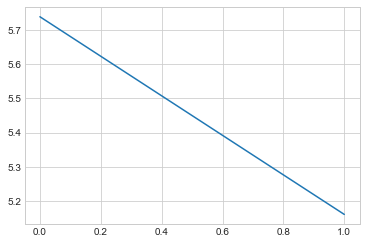

In [80]:
plt.plot(history.history["loss"])

In [81]:
embedding = model.embedding

In [130]:
from collections import Counter
n = 150
top_n, _ = (["would", "should", "could", "may", "shall",
             "he", "she", "his", "my", "their"], None) #list(zip(*Counter(test_sentence).most_common(n)))

test_raw = [word.lower() for word in top_n]
test_words = [word_to_ix[word.lower()] for word in top_n]

In [131]:
embed_xy = embedding(np.array(test_words))[:, :2].numpy()
embed_x, embed_y = list(zip(*embed_xy))

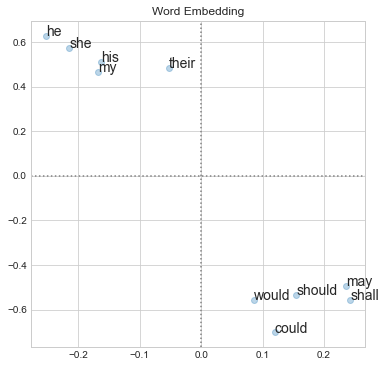

In [133]:
plt.figure(figsize=(6,6))
plt.title("Word Embedding")
plt.scatter(embed_x, embed_y, alpha=.3)
plt.axhline([0], ls=":", c="grey")
plt.axvline([0], ls=":", c="grey")
for xy, word in zip(embed_xy, test_raw):
    plt.annotate(word.lower(), xy, fontsize=14)

## Exercise: Continuous Bag-of-words

Given a target word $w_i$ and an $N$ context window on each side, $w_{i−1},\cdots,w_{i−N}$ and $w_{i+1},\cdots,w_{i+N}$, referring to all context words collectively as C, CBOW tries to minimize

$$
-\log p(w_i | C) = -\log \text{Softmax}(A(\sum_{w \in C} q_w) + b)
$$

where $q_w$ is the embedding for word $w$.

In [43]:
CONTEXT_SIZE = 2  # 2 words to the left, 2 to the right
EMBEDDING_DIM = 2

In [44]:
raw_text = """We are about to study the idea of a computational process.
Computational processes are abstract beings that inhabit computers.
As they evolve, processes manipulate other abstract things called data.
The evolution of a process is directed by a pattern of rules
called a program. People create programs to direct processes. In effect,
we conjure the spirits of the computer with our spells.""".split()

In [45]:
# By deriving a set from `raw_text`, we deduplicate the array
vocab = set(raw_text)
vocab_size = len(vocab)

word_to_ix = {word.lower(): i for i, word in enumerate(vocab)}
data = []
for i in range(2, len(raw_text) - 2):
    context = [raw_text[i - 2], raw_text[i - 1],
               raw_text[i + 1], raw_text[i + 2]]
    target = raw_text[i]
    data.append((context, target))

data[:5]

[(['We', 'are', 'to', 'study'], 'about'),
 (['are', 'about', 'study', 'the'], 'to'),
 (['about', 'to', 'the', 'idea'], 'study'),
 (['to', 'study', 'idea', 'of'], 'the'),
 (['study', 'the', 'of', 'a'], 'idea')]

Define the model

In [46]:
class CBOW(nn.Module):
    
    def __init__(self):
        super(CBOW, self).__init__()
        self.embedding = nn.Embedding(vocab_size, EMBEDDING_DIM)
        self.linear1 = nn.Linear(2*CONTEXT_SIZE*EMBEDDING_DIM, 128)
        self.linear2 = nn.Linear(128, vocab_size)
    
    def forward(self, x):
        x = self.embedding(x)
        x = x.view(1, -1)
        
        x = F.relu(self.linear1(x))
        x = F.log_softmax(self.linear2(x), dim=1)
        return x

Train the model

In [47]:
model = CBOW()
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)

In [48]:
def make_context_vector(context, word_to_ix):
    idxs = [word_to_ix[w.lower()] for w in context]
    return torch.tensor(idxs, dtype=torch.long)

make_context_vector(data[0][0], word_to_ix)  # example

tensor([16,  6, 15, 13])

In [49]:
N_EPOCH = 200
loss_history = []

for i in range(1, N_EPOCH+1):
    loss_epoch = 0.
    for context, target in data:
        context_idx = make_context_vector(context, word_to_ix)
        target_idx = torch.tensor([word_to_ix[target.lower()]], dtype=torch.long)
        
        model.zero_grad()
        out = model(context_idx)
        loss = criterion(out, target_idx)
        loss.backward()
        optimizer.step()
        
        loss_epoch += loss.item()
    
    loss_history.append(loss_epoch)
    if i % 20 == 0: print(f"[{i}] loss: {loss_epoch: .2f}")

[20] loss:  2.83
[40] loss:  0.76
[60] loss:  0.41
[80] loss:  0.27
[100] loss:  0.20
[120] loss:  0.16
[140] loss:  0.13
[160] loss:  0.11
[180] loss:  0.09
[200] loss:  0.08


Results

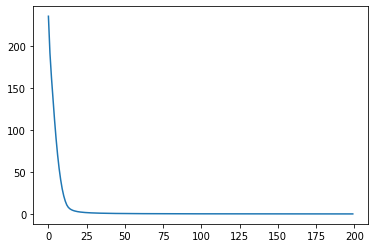

In [50]:
plt.plot(loss_history)

In [51]:
embedding = model.embedding

In [52]:
test_words = [word_to_ix[word.lower()] for word in raw_text[:50]]

In [53]:
with torch.no_grad():
    embed_xy = embedding(torch.tensor(test_words))[:, :2].detach().numpy()
embed_x, embed_y = list(zip(*embed_xy))

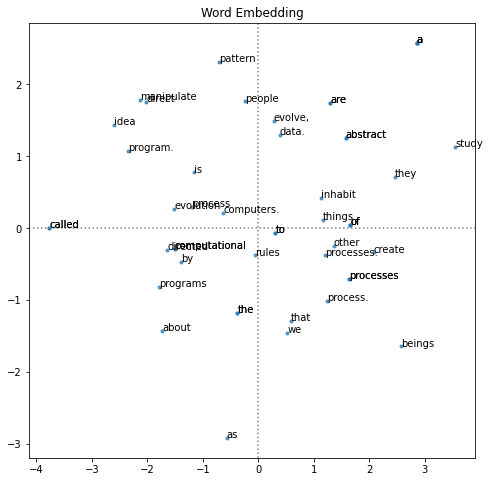

In [54]:
plt.figure(figsize=(6,6))
plt.title("Word Embedding")
plt.scatter(embed_x, embed_y, marker=".", alpha=.7)
plt.axhline([0], ls=":", c="grey")
plt.axvline([0], ls=":", c="grey")
for xy, word in zip(embed_xy, raw_text[:50]):
    plt.annotate(word.lower(), xy)